<img style="float: left; padding-right: 10px; width: 45px" src="https://upload.wikimedia.org/wikipedia/fr/b/b1/Logo_EPF.png?raw=true"> 

# Introduction to Machine Learning
**P2023: Data engineering**<br>


## Lab 3:  Dealing with imbalanced datasets

### First name: Maxime
### Last name: Raillat
### Group: A1


---

# Introduction
Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of observations in each class.  Class imbalance can be found in many different areas including medical diagnosis, spam filtering, ad-click prediction and fraud detection.

In this guide, we'll look at five possible ways to handle an imbalanced class problem using credit card data. <br>**Our objective will be to correctly classify fraudulent credit card transactions.**

In [1]:
# useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

In [3]:
# read in data
df = pd.read_csv('creditcard_sampled_10_percent.csv')

print(df.shape)
df.head()

(28481, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,59632.0,-0.365570,0.857326,1.601891,1.276523,0.265923,0.225669,0.456214,0.188240,-0.692619,...,0.087559,0.473280,-0.137397,0.244391,-0.272493,-0.283047,0.193123,0.143190,1.00,0
1,62189.0,1.023773,-0.193395,1.276809,1.271923,-0.847045,0.411318,-0.720179,0.374841,0.878952,...,0.051391,0.273518,0.102789,0.057612,0.152152,-0.372631,0.091121,0.035413,23.42,0
2,75530.0,-0.997827,0.925281,0.616181,0.009446,-0.025082,-0.828361,0.628374,0.276775,-0.991345,...,0.155928,0.328605,0.179409,0.351494,-0.285212,0.238287,-0.118637,0.033654,42.81,0
3,99940.0,-2.950527,-1.300757,1.421298,3.134102,4.604562,-1.773035,-0.561876,0.129093,-1.034959,...,0.397170,0.443959,-0.201887,-0.371432,1.441045,0.293148,-0.188636,0.073548,1.00,0
4,168047.0,2.089662,0.064907,-2.295436,0.318867,0.781676,-0.648774,0.281364,-0.187433,0.576539,...,-0.276488,-0.754165,0.155672,-0.082590,-0.027077,0.380547,-0.084189,-0.042292,18.79,0


**In the complete dataset, there are 492 fraudulent operations and 284315 valid operations.** <br>

**However, during the lab, we will use a sampled dataset. You can however play with the real dataset afterwards**

In [4]:
print(df.Class.value_counts())

0    28429
1       52
Name: Class, dtype: int64


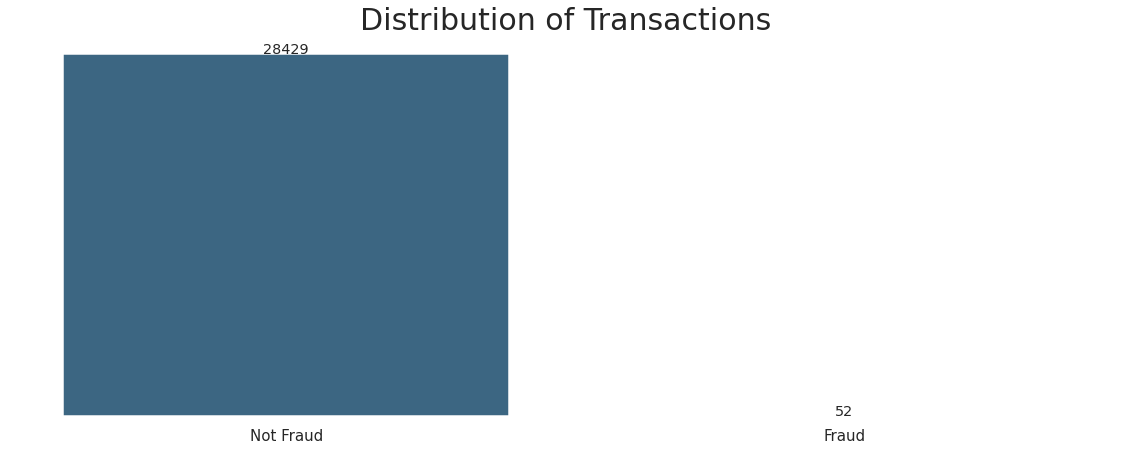

In [5]:
# using seaborns countplot to show distribution of transactions in dataset
fig, ax = plt.subplots()
g = sns.countplot(df.Class, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

**Exercise :** 
Compute the percentage of fraudulent transactions (ie: when Class == 1)

In [6]:
# TODO: Code here
(df[df["Class"]==1].count()[0]/df.shape[0])*100

0.18257785892349285

From the plot above, we can see we have a very imbalanced class -  just 0.17% of our dataset belong to the target class!

This is a problem because many machine learning models are designed to maximize overall accuracy, which especially with imbalanced classes may not be the best metric to use. Classification accuracy is defined as the number of correct predictions divided by total predictions times 100. For example, if we simply predicted all transactions are not fraud, we would get a classification acuracy score of over 99%!

### Create Train and Test Sets

The training set is used to build and validate the model, while the test set is reserved for testing the model on unseen data.

**Exercise :** Separate the dataset into y and X. y being the traget column and X the features.

In [7]:
df_X= df.copy()
del df_X["Class"]


In [8]:
from sklearn.model_selection import train_test_split

# Prepare data for modeling
# TODO: Code here
y = df["Class"]
X =  df_X

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

## Baseline Models

In [9]:
from sklearn.dummy import DummyClassifier

# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

# checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

Unique predicted labels:  [0]


As we can see, our Dummy Classifier predicts target == 0 (No fraud) for all the test set. <br>

**Exerice :** Compute the accuracy of the dummy classifier using two different ways :
*   First with your own code (can be a loop or manipulation of numpy arrays)
*   Then using `accuracy_score` from `sklearn.metrics`

**Accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition:**
$$ \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Number of total predictions}}$$


In [10]:
# TODO: Code here
# TODO: accuracy with your own code
Accuracy = sum(dummy_pred == y_test)/len(dummy_pred)
print(Accuracy)
# TODO: accuracy with sklearn using sklearn.metrics.accuracy_score
sklearn.metrics.accuracy_score(dummy_pred,y_test)

0.9985957028507232


0.9985957028507232

As predicted our accuracy score for classifying all transactions as not fraud is very high!  

As the Dummy Classifier predicts only Class 0, it is clearly not a good option for our objective of correctly classifying fraudulent transactions.

Let's see how logistic regression performs on this dataset.

In [11]:
from sklearn.linear_model import LogisticRegression

# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
 
# Predict on training set
lr_pred = lr.predict(X_test)

In [12]:
# Checking accuracy
sklearn.metrics.accuracy_score(y_test, lr_pred)

0.9994382811402893

In [13]:
# Checking unique values
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    7115
1       6
Name: 0, dtype: int64

Logistic Regression outperformed the Dummy Classifier!  We can see that it predicted some instances of class 1, so this is definitely an improvement.  But can we do better?

Let's see if we can apply some techniques for dealing with class imbalance to improve these results.

## 1.  Change the performance metric
Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.  Metrics that can provide better insight include:
 - **Confusion Matrix:**  a talbe showing correct predictions and types of incorrect predictions.
 - **Precision:**  the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.
 - **Recall:**  the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.
 - **F1: Score:**  the weighted average of precision and recall.
 
Since our main objective with the dataset is to prioritize accuraltely classifying fraud cases the recall score can be considered our main metric to use for evaluating outcomes.<br>

**How do we compute these metrics :**
Let's code these metrics ourselves to make sure we understand what it is.

**Exercise :** For the LogisticRegression model, compute true positives (`tp`), false positives (`fp`), false negatives (`fn`), true negatives (`tn`). You can find the formal definitions here https://en.wikipedia.org/wiki/Confusion_matrix

Hypothesis :
H0 : Prediction  is good 
H1 : Prediction is not good 

In [14]:
lr_pred==0

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
# TODO: Code here
tp = sum((lr_pred==1) & (y_test==1))
tn = sum((lr_pred==0) & (y_test==0))
fp  = sum((lr_pred==1) & (y_test==0)) # predit 1 alors que c'est 0 
fn = sum((lr_pred==0) & (y_test==1)) # predit 0 alors que c'est 1
print("Tp:",tp,"tn",tn,"fn",fn,"fp",fp)


Tp: 6 tn 7111 fn 4 fp 0


**Exercise :** Compute the metrics `Precision`, `Recall` and `f1-score`.

In [16]:
Precision = tp / sum(lr_pred==1)
Recall = tp / sum(y_test==1)
F1_score = (2*tp)/(2*tp+fp+fn)
Precision,Recall,F1_score

(1.0, 0.6, 0.75)

In [17]:
# TODO: Code here
sklearn.metrics.precision_score(y_test,lr_pred)
sklearn.metrics.recall_score(y_test,lr_pred)
sklearn.metrics.f1_score(y_test,lr_pred)

0.7499999999999999

**How do we compute these metrics using sklearn:**
Let's see how we compute these metrics using `sklearn.metrics`. We'll do it for the `LogisticRegression`. We need `y_test` which are the real test observations and we need `lr_pred` which are the predictions of the `LogisticRegression` on the test set.

In [18]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

# Example on LogisticRegression
print('Accuracy is ', accuracy_score(y_test, lr_pred))
print('F1-score is ', f1_score(y_test, lr_pred))
print('Recall is ', recall_score(y_test, lr_pred))
print('Confusion matrix is ')
pd.DataFrame(confusion_matrix(y_test, lr_pred)).head(2)

Accuracy is  0.9994382811402893
F1-score is  0.7499999999999999
Recall is  0.6
Confusion matrix is 


,0,1
0,7111,0
1,4,6


We have a very high accuracy score of 0.999 but a F1 score of only 0.752.  And from the confusion matrix, we can see we are misclassifying several observations leading to a recall score of only 0.64.

## 2. Change the algorithm
While in every machine learning problem, its a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets.  Decision trees frequently perform well on imbalanced data.  They work by learning a hierachy of if/else questions.  This can force both classes to be addressed.



**Exercise** Use a `RandomForestClassifier` with `n_estimators=10` and compute the usual metrics (accuracy, f1-score, recall and confusion matrix)

In [19]:
# TODO: Code here
from sklearn.ensemble import RandomForestClassifier
Rfc= RandomForestClassifier(n_estimators=10,bootstrap=True,random_state=42)
Rfc.fit(X_train,y_train)
y_predict = Rfc.predict(X_test)



In [20]:
print('Accuracy is ', accuracy_score(y_test, y_predict))
print('F1-score is ', f1_score(y_test, y_predict))
print('Recall is ', recall_score(y_test, y_predict))
print('Confusion matrix is ')
pd.DataFrame(confusion_matrix(y_test, y_predict)).head(2)

Accuracy is  0.999578710855217
F1-score is  0.8235294117647058
Recall is  0.7
Confusion matrix is 


,0,1
0,7111,0
1,3,7


# Resampling Techniques

## 3. Oversampling Minority Class
Oversampling can be defined as adding more copies of the minority class.  Oversampling can be a good choice when you don't have a ton of data to work with.  A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

We will use the resampling module from Scikit-Learn to randomly replicate samples from the minority class.

### **Important Note**
Always split into test and train sets BEFORE trying any resampling techniques!  Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets!  This can allow our model to simply memorize specific data points and cause overfitting.

In [21]:
from sklearn.utils import resample

In [22]:
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [23]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
7323,132230.0,1.797014,-0.620617,-3.089936,0.195394,0.903350,-1.025187,1.135037,-0.538027,0.093220,...,0.319507,0.526784,-0.393472,0.177619,0.606809,1.006654,-0.201444,-0.062785,219.00,0
13708,36203.0,1.127534,-1.743518,-0.007402,-2.623771,-1.333444,-0.011875,-0.772654,-0.052193,1.656981,...,-0.497790,-0.917727,-0.304940,-0.993739,0.632809,-0.770682,0.102616,0.054434,185.41,0
27219,936.0,-1.331879,1.621242,0.590870,1.333507,-0.574223,-0.108092,-0.214766,1.040828,-0.257084,...,0.002048,0.124593,-0.048547,0.063000,-0.037439,-0.210650,0.285472,0.124636,5.99,0
10573,114587.0,1.628844,-1.065076,-0.497869,0.159299,-1.157159,-1.072094,-0.130069,-0.215774,1.148935,...,-0.311983,-1.179808,0.393706,0.482117,-0.893336,0.716274,-0.126618,-0.018556,200.53,0
4755,43872.0,1.254027,-0.792932,0.242420,-0.446319,-0.940256,-0.424515,-0.499335,-0.050957,-0.423494,...,0.105934,0.292283,-0.115116,0.101954,0.571071,-0.119523,0.007714,0.013177,64.96,0


In [24]:
# separate minority and majority classes
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproductible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

0    21318
1    21318
Name: Class, dtype: int64

**Exerise** Train a model (`LogisticRegression` for example) on the `upsampled` data and compute the usual metrics.

In [25]:

# TODO: Code here

y = upsampled.Class
X = upsampled.drop('Class', axis=1)

# setting up testing and training sets


# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X, y)
 
# Predict on training set
lr_pred = lr.predict(X_test)

print('Accuracy is ', accuracy_score(y_test, lr_pred))
print('F1-score is ', f1_score(y_test, lr_pred))
print('Recall is ', recall_score(y_test, lr_pred))
print('Confusion matrix is ')
pd.DataFrame(confusion_matrix(y_test, lr_pred)).head(2)

Accuracy is  0.97640780789215
F1-score is  0.10638297872340426
Recall is  1.0
Confusion matrix is 


,0,1
0,6943,168
1,0,10


**Exercise** Compare the results with what we have seen before

**Answer here  This depends of what you want , do you prefer to accecpt fraud transaction or stopping good transaction, in my opinion i prefer the first mathod :)** 

## 4. Undersampling Majority Class
Undersampling can be defined as removing some observations of the majority class.  Undersampling can be a good choice when you have a ton of data -think millions of rows.  But a drawback to undersampling is that we are removing information that may be valuable.

We will again use the resampling module from Scikit-Learn to randomly remove samples from the majority class.

In [26]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

0    42
1    42
Name: Class, dtype: int64

**Exerise** Train a model (`LogisticRegression` for example) on the `downsampled` data and compute the usual metrics.

In [27]:
# TODO: Code here

y = downsampled.Class
X = downsampled.drop('Class', axis=1)

# setting up testing and training sets


# Modeling the data as is
# Train model
lr = LogisticRegression(solver='liblinear').fit(X, y)
 
# Predict on training set
lr_pred = lr.predict(X_test)

print('Accuracy is ', accuracy_score(y_test, lr_pred))
print('F1-score is ', f1_score(y_test, lr_pred))
print('Recall is ', recall_score(y_test, lr_pred))
print('Confusion matrix is ')
pd.DataFrame(confusion_matrix(y_test, lr_pred)).head(2)

Accuracy is  0.9594158123859009
F1-score is  0.06472491909385113
Recall is  1.0
Confusion matrix is 


,0,1
0,6822,289
1,0,10


**Exercise** Compare the results with what we have seen before

**Answer here In this case downsampling is less efficient than overslamping** 

## 5. Generate Synthetic Samples
SMOTE or Synthetic Minority Oversampling Technique is a popular algorithm to creates sythetic observations of the minority class.

In [29]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [30]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)

**Exercise** Compute metrics for these predictions

In [31]:
print('Accuracy is ', accuracy_score(y_test, smote_pred))
print('F1-score is ', f1_score(y_test, smote_pred))
print('Recall is ', recall_score(y_test, smote_pred))
print('Confusion matrix is ')
pd.DataFrame(confusion_matrix(y_test, smote_pred)).head(2)

Accuracy is  0.9869400365117259
F1-score is  0.16216216216216217
Recall is  0.9
Confusion matrix is 


,0,1
0,7019,92
1,1,9


## Conclusion

We covered 5 different methods for dealing with imbalanced datasets:
1.  Change the performance metric
2.  Oversampling minority class
3.  Undersampling majority class
4.  Change the algorithm
5.  Generate synthetic samples

These are just some of the many possible methods to try when dealing with imbalanced datasets, and not an exhaustive list.  Some others methods to consider are collecting more data or choosing different resampling ratios - you don't have to have exactly a 1:1 ratio!  You should always try several approaches and then decide which is best for your problem.